# Global fit to all three K2 campaign lightcurves

In [2]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## SHO model

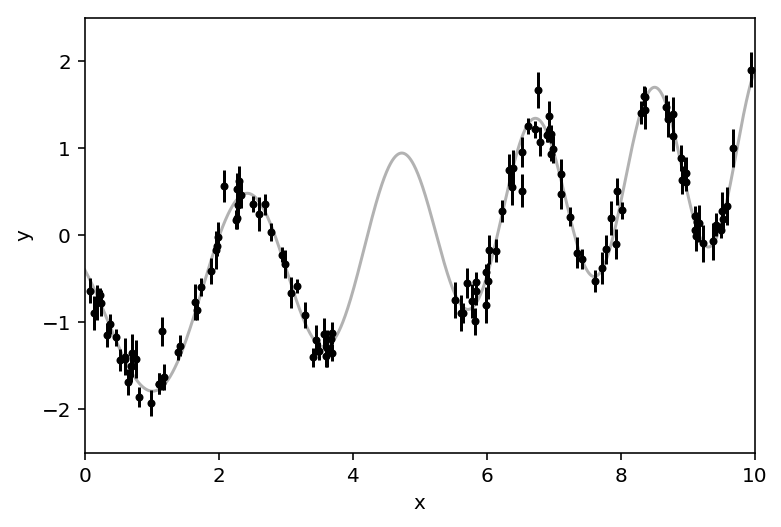

In [3]:
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [ ]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)


In [ ]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

In [ ]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))


In [ ]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

In [ ]:
gp.get_parameter_dict()

In [ ]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [ ]:
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [ ]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

# subsub K2

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
! ls ../data/K2/

S1063_K2_C05_lightkurve_SFF.csv S1063_K2_C18_lightkurve_SFF.csv
S1063_K2_C16_lightkurve_SFF.csv


In [3]:
dfC05 = pd.read_csv('../data/K2/S1063_K2_C05_lightkurve_SFF.csv')
dfC16 = pd.read_csv('../data/K2/S1063_K2_C16_lightkurve_SFF.csv')
dfC18 = pd.read_csv('../data/K2/S1063_K2_C18_lightkurve_SFF.csv')

In [4]:
df = pd.concat([dfC16, dfC18], ignore_index=True)
#df = pd.concat([dfC05], ignore_index=True)
df['flux'] = df.flux / np.percentile(df.flux, 98)

#df = pd.concat([dfC16], ignore_index=True)
#df['flux'] = df.flux / np.percentile(df.flux, 98)

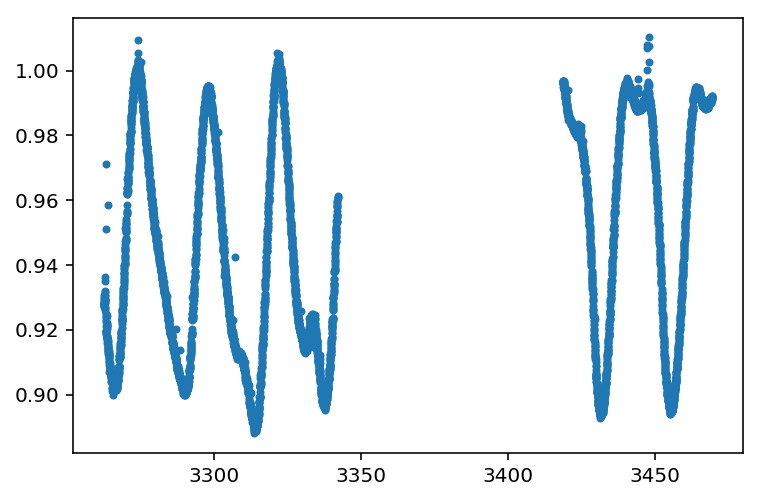

In [5]:
plt.plot(df.time, df.flux, '.')

In [6]:
mask1 = (df.time > 3308) & (df.time < 3319) # C16
mask2 = (df.time > 3439) & (df.time < 3455) # C18
#mask = (df.time < 2340) & (df.time > 2325) # C05

In [7]:
df_subset = df[~mask1 & ~mask2]
#df_subset = df[~mask]

In [8]:
t = df_subset.time.values
y = df_subset.flux
yerr = 0.001 * np.ones(len(t))

<ErrorbarContainer object of 3 artists>

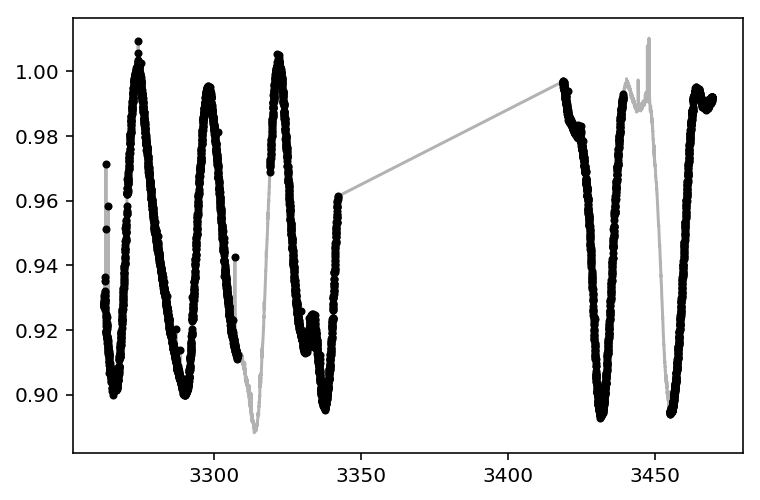

In [9]:
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.99, 1.0)
#plt.xlim(3272, 3273)

<ErrorbarContainer object of 3 artists>

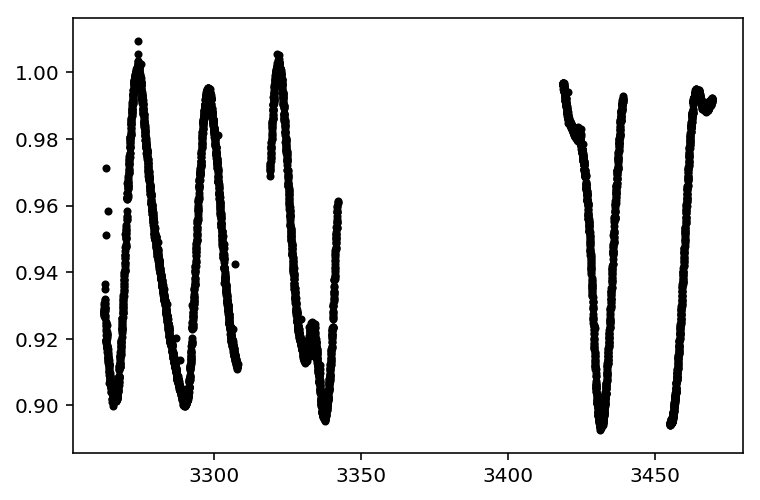

In [10]:
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.985, 1.0)
#plt.xlim(3272, 3273)

In [11]:
2.0 * np.pi / 23.5, 2.0 * np.pi / 13

(0.26736958753955686, 0.483321946706122)

In [12]:
import celerite
from celerite import terms

# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [13]:
%%time
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 23599.527960187253
CPU times: user 2.49 ms, sys: 1.69 ms, total: 4.18 ms
Wall time: 10.1 ms


In [14]:
x = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/24/2.0)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'y')

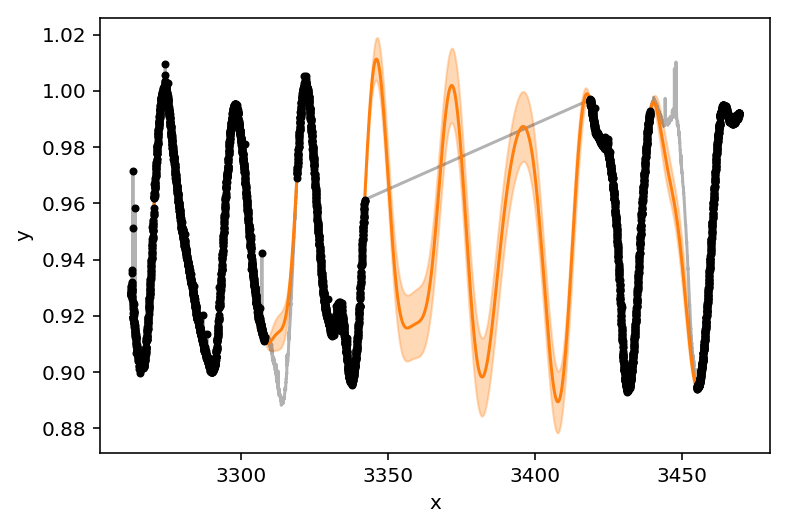

In [15]:
color = "#ff7f0e"
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

(3272, 3273)

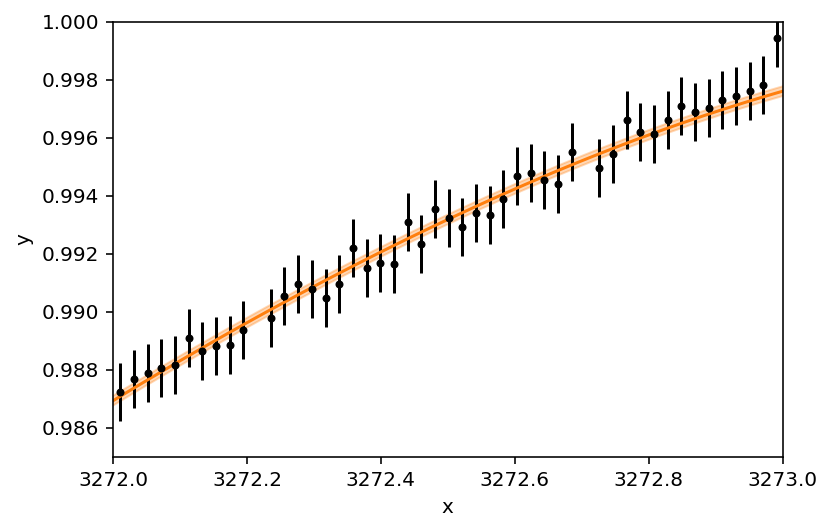

In [16]:
color = "#ff7f0e"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0.985, 1.0)
plt.xlim(3272, 3273)

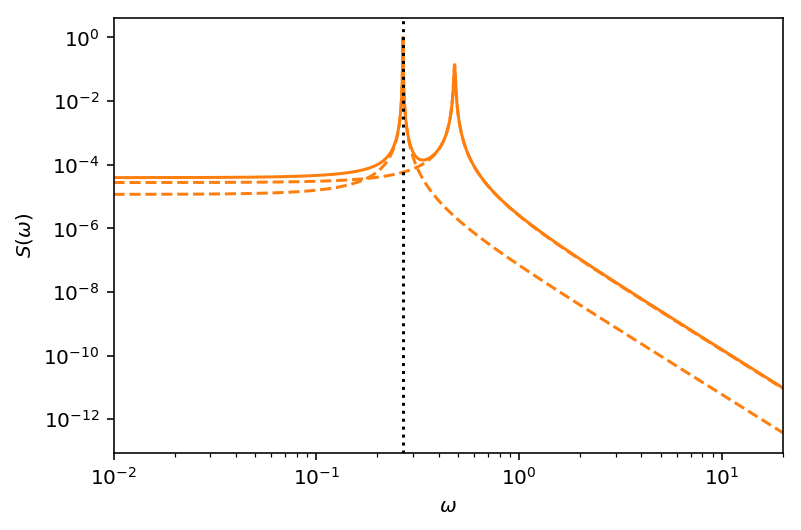

In [17]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [18]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -23705.587431170323
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.30559022,  1.41772034,  0.14952093, -0.76252036, -2.19479261])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 21
   status: 0
  success: True
        x: array([ -8.15906818,  -0.69260383, -11.1481375 ,   5.33930701,
        -1.33913728])


In [19]:
np.pi*2/10**-0.8290087063581993, np.pi*2/10**-1.3457165415991024

(42.382695572041094, 139.28245400025708)

In [20]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -8.159068184679692),
             ('kernel:terms[0]:log_omega0', -0.6926038298550256),
             ('kernel:terms[1]:log_S0', -11.148137504371059),
             ('kernel:terms[1]:log_Q', 5.33930701423249),
             ('kernel:terms[1]:log_omega0', -1.3391372763957494)])

In [21]:
x = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/24/2.0)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'y')

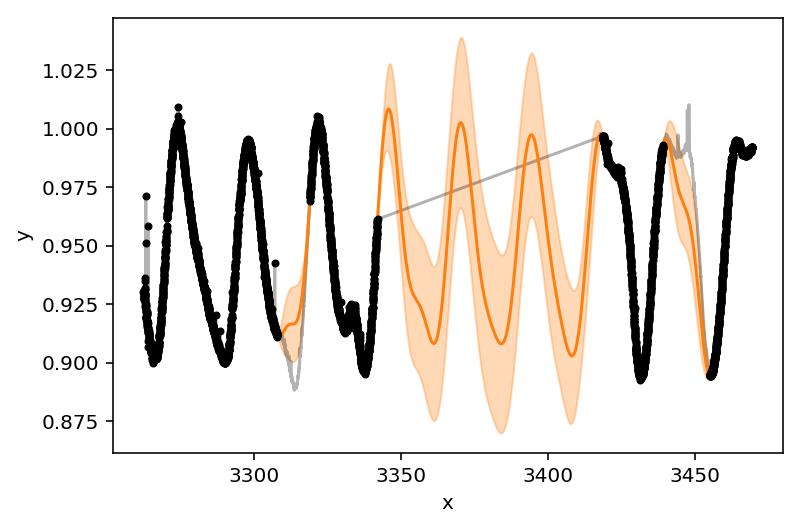

In [22]:
color = "#ff7f0e"
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

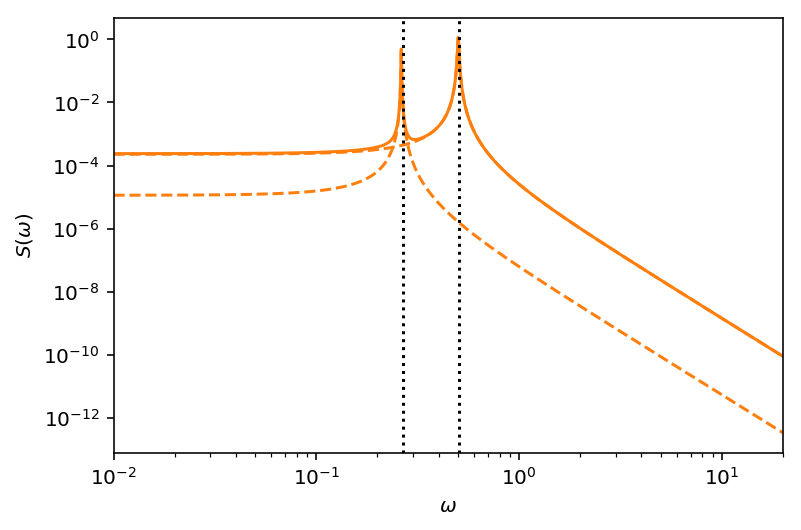

In [26]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')
plt.axvline(2.0*np.pi/12.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");